In [13]:
# Import Packages
!pip install gymnasium
import gym
import numpy as np
from numpy.typing import NDArray
from typing import List, Tuple, Deque, Optional, Callable
import time
import torch
from torch.optim.lr_scheduler import _LRScheduler
from tqdm.notebook import tqdm
import collections
import gymnasium as gym
import itertools
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import random
import time
import torch
from torch.optim.lr_scheduler import _LRScheduler
from typing import List, Tuple, Deque, Optional, Callable
import seaborn as sns
import sys, subprocess
import heapq
import math

def is_colab():
    return "google.colab" in sys.modules

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

if is_colab():
    run_subprocess_command("apt install swig xvfb x11-utils")
    run_subprocess_command("pip install gymnasium[box2d] pyvirtualdisplay cma")
# To display GIF images in the notebook

import imageio     # To render episodes in GIF images (otherwise there would be no render on Google Colab)
                   # C.f. https://stable-baselines.readthedocs.io/en/master/guide/examples.html#bonus-make-a-gif-of-a-trained-agent
import IPython
from IPython.display import Image

if is_colab():
    import pyvirtualdisplay

    _display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                        size=(1400, 900))
    _ = _display.start()

class RenderWrapper:
    def __init__(self, env, force_gif=False):
        self.env = env
        self.force_gif = force_gif
        self.reset()

    def reset(self):
        self.images = []

    def render(self):
        if not is_colab():
            self.env.render()
            time.sleep(1./60.)

        if is_colab() or self.force_gif:
            img = self.env.render()         # Assumes env.render_mode == 'rgb_array'
            self.images.append(img)

    def make_gif(self, filename="render"):
        if is_colab() or self.force_gif:
            imageio.mimsave(filename + '.gif', [np.array(img) for i, img in enumerate(self.images) if i%2 == 0], fps=29, loop=0)
            return Image(open(filename + '.gif','rb').read())

    @classmethod
    def register(cls, env, force_gif=False):
        env.render_wrapper = cls(env, force_gif=True)


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
# Setup PyTorch Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to CUDA if available, otherwise use CPU
print(f"PyTorch will train neural networks on {device}")

PyTorch will train neural networks on cuda


In [15]:
class EpsilonGreedy:
    """
    An Epsilon-Greedy policy.

    Attributes
    ----------
    epsilon : float
        The initial probability of choosing a random action.
    epsilon_min : float
        The minimum probability of choosing a random action.
    epsilon_decay : float
        The decay rate for the epsilon value after each action.
    env : gym.Env
        The environment in which the agent is acting.
    q_network : torch.nn.Module
        The Q-Network used to estimate action values.

    Methods
    -------
    __call__(state: np.ndarray) -> np.int64
        Select an action for the given state using the epsilon-greedy policy.
    decay_epsilon()
        Decay the epsilon value after each action.
    """

    def __init__(self,
                 epsilon_start: float,
                 epsilon_min: float,
                 epsilon_decay:float,
                 env: gym.Env,
                 q_network: torch.nn.Module):
        """
        Initialize a new instance of EpsilonGreedy.

        Parameters
        ----------
        epsilon_start : float
            The initial probability of choosing a random action.
        epsilon_min : float
            The minimum probability of choosing a random action.
        epsilon_decay : float
            The decay rate for the epsilon value after each episode.
        env : gym.Env
            The environment in which the agent is acting.
        q_network : torch.nn.Module
            The Q-Network used to estimate action values.
        """
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.env = env
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:
        """
        Select an action for the given state using the epsilon-greedy policy.

        If a randomly chosen number is less than epsilon, a random action is chosen.
        Otherwise, the action with the highest estimated action value is chosen.

        Parameters
        ----------
        state : np.ndarray
            The current state of the environment.

        Returns
        -------
        np.int64
            The chosen action.
        """

        # TODO...

        if np.random.rand() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            # print('Inside Epsilon Greedy:', state.shape)
            state = np.expand_dims(state, axis=0)
            q_vals = self.q_network(torch.tensor(state, dtype=torch.float32).to(device)).to(device)
            action = q_vals.argmax().item()

        return action

    def decay_epsilon(self):
        """
        Decay the epsilon value after each episode.

        The new epsilon value is the maximum of `epsilon_min` and the product of the current
        epsilon value and `epsilon_decay`.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [16]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):
        """
        Initialize a new instance of MinimumExponentialLR.

        Parameters
        ----------
        optimizer : torch.optim.Optimizer
            The optimizer whose learning rate should be scheduled.
        lr_decay : float
            The multiplicative factor of learning rate decay.
        last_epoch : int, optional
            The index of the last epoch. Default is -1.
        min_lr : float, optional
            The minimum learning rate. Default is 1e-6.
        """
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self) -> List[float]:
        """
        Compute learning rate using chainable form of the scheduler.

        Returns
        -------
        List[float]
            The learning rates of each parameter group.
        """
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

In [17]:
class ReplayBuffer:
    """
    A Replay Buffer.

    Attributes
    ----------
    buffer : collections.deque
        A double-ended queue where the transitions are stored.

    Methods
    -------
    add(state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool)
        Add a new transition to the buffer.
    sample(batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]
        Sample a batch of transitions from the buffer.
    __len__()
        Return the current size of the buffer.
    """

    def __init__(self, capacity: int):
        """
        Initializes a ReplayBuffer instance.

        Parameters
        ----------
        capacity : int
            The maximum number of transitions that can be stored in the buffer.
        """
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool):
        """
        Add a new transition to the buffer.

        Parameters
        ----------
        state : np.ndarray
            The state vector of the added transition.
        action : np.int64
            The action of the added transition.
        reward : float
            The reward of the added transition.
        next_state : np.ndarray
            The next state vector of the added transition.
        done : bool
            The final state of the added transition.
        """
        # print(type(state))
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]:
        """
        Sample a batch of transitions from the buffer.

        Parameters
        ----------
        batch_size : int
            The number of transitions to sample.

        Returns
        -------
        Tuple[np.ndarray, float, float, np.ndarray, bool]
            A batch of `batch_size` transitions.
        """
        # Here, `random.sample(self.buffer, batch_size)`
        # returns a list of tuples `(state, action, reward, next_state, done)`
        # where:
        # - `state`  and `next_state` are numpy arrays
        # - `action` and `reward` are floats
        # - `done` is a boolean
        #
        # `states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))`
        # generates 5 tuples `state`, `action`, `reward`, `next_state` and `done`, each having `batch_size` elements.
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        # for i in range(len(states)):
        #     print(type(states[i]))
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        """
        Return the current size of the buffer.

        Returns
        -------
        int
            The current size of the buffer.
        """
        return len(self.buffer)

In [18]:
def test_q_network_agent(env: gym.Env, q_network: torch.nn.Module, num_episode: int = 1, render: bool = True) -> List[int]:
    """
    Test a naive agent in the given environment using the provided Q-network.

    Parameters
    ----------
    env : gym.Env
        The environment in which to test the agent.
    q_network : torch.nn.Module
        The Q-network to use for decision making.
    num_episode : int, optional
        The number of episodes to run, by default 1.
    render : bool, optional
        Whether to render the environment, by default True.

    Returns
    -------
    List[int]
        A list of rewards per episode.
    """
    episode_reward_list = []

    for episode_id in range(num_episode):

        state, info = env.reset()
        done = False
        episode_reward = 0

        while not done:
            if render:
                env.render_wrapper.render()
            # Convert the state to a PyTorch tensor and add a batch dimension (unsqueeze)
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action = torch.argmax(q_network(state_tensor)).item()

            next_state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            state = next_state

        episode_reward_list.append(episode_reward)
        print(f"Episode reward: {episode_reward}")

    return episode_reward_list

## DQN

In [19]:
class QNetwork(torch.nn.Module):
    """
    A Q-Network implemented with PyTorch.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        First fully connected layer.
    layer2 : torch.nn.Linear
        Second fully connected layer.
    layer3 : torch.nn.Linear
        Third fully connected layer.

    Methods
    -------
    forward(x: torch.Tensor) -> torch.Tensor
        Define the forward pass of the QNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int, nn_l1: int, nn_l2: int):
        """
        Initialize a new instance of QNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        nn_l1 : int
            The number of neurons on the first layer.
        nn_l2 : int
            The number of neurons on the second layer.
        """
        super(QNetwork, self).__init__()

        self.l1 = torch.nn.Linear(n_observations, nn_l1)
        self.l2 = torch.nn.Linear(nn_l1, nn_l2)
        self.final_layer = torch.nn.Linear(nn_l2, n_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define the forward pass of the QNetwork.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor (state).

        Returns
        -------
        torch.Tensor
            The output tensor (Q-values).
        """
        
        x = x.to(device)
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        x = self.final_layer(x)

        return x

Episode reward: -223.7691463420127
Episode reward: -330.6226717650097
Episode reward: -572.2188319789153
Episode reward: -168.22712802994255
Episode reward: -145.4174936542385


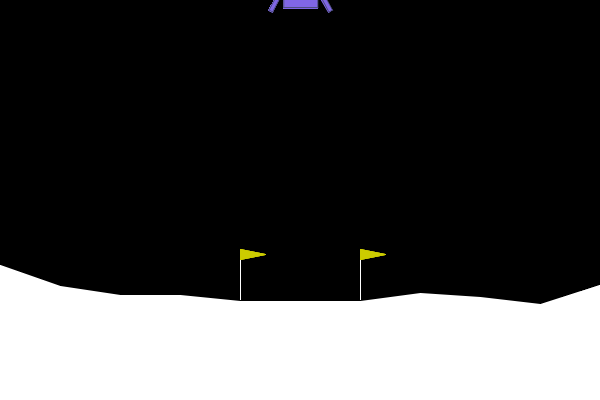

In [20]:
q_network = torch.load("dqn_q_network.pth").to(device)

env = gym.make('LunarLander-v2', render_mode = 'rgb_array')
RenderWrapper.register(env, force_gif=True)

test_q_network_agent(env, q_network, num_episode=5)

env.close()

env.render_wrapper.make_gif("dqn_2015")

## DDQN

In [21]:
class DuelingQNetwork(torch.nn.Module):
    def __init__(self, n_observations, n_actions, nn_l1, nn_l2):
        super(DuelingQNetwork, self).__init__()

        self.feature_layer = torch.nn.Linear(n_observations, nn_l1)

        # Value stream
        self.value_stream = torch.nn.Sequential(
            torch.nn.Linear(nn_l1, nn_l2),
            torch.nn.ReLU(),
            torch.nn.Linear(nn_l2, 1)  # Output is the value of the state
        )

        # Advantage stream
        self.advantage_stream = torch.nn.Sequential(
            torch.nn.Linear(nn_l1, nn_l2),
            torch.nn.ReLU(),
            torch.nn.Linear(nn_l2, n_actions)  # Output is the advantage of each action
        )

    def forward(self, x):
        # print('Inside Q Network:', x.shape)
        x = x.to(device)
        x = torch.relu(self.feature_layer(x)).to(device)

        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        # Combine the value and advantage streams
        # print(type(advantage))
        # print(advantage.shape)
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))

        return q_values

Episode reward: -273.5494586507367
Episode reward: -166.10227941193148
Episode reward: -344.99727897474827
Episode reward: -341.2457695164023
Episode reward: -321.67086452864487


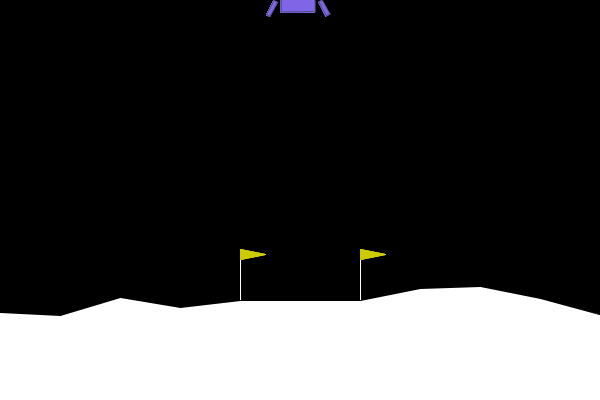

In [22]:
q_network = torch.load("online_q_network_dddqn.pth").to(device)

env = gym.make('LunarLander-v2', render_mode = 'rgb_array')
RenderWrapper.register(env, force_gif=True)

test_q_network_agent(env, q_network, num_episode=5)

env.close()

env.render_wrapper.make_gif("ddqn")

## DQN with Priority Buffer Queue

In [27]:
class ReplayBufferWithPriorityQueue:
    """
    A Replay Buffer with priority queue.

    Attributes
    ----------
    buffer : priority_queue

    Methods
    -------
    add(state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool)
        Add a new transition to the buffer.
    sample(batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]
        Sample a batch of transitions from the buffer.
    _len_()
        Return the current size of the buffer.
    """

    def __init__(self, capacity: int):
        """
        Initializes a ReplayBuffer instance.

        Parameters
        ----------
        capacity : int
            The maximum number of transitions that can be stored in the buffer.
        """
        self.buffer = PriorityQueue()

    def add(self, state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool, td_error: float):
        """
        Add a new transition to the buffer and sort the buffer.

        Parameters
        ----------
        state : np.ndarray
            The state vector of the added transition.
        action : np.int64
            The action of the added transition.
        reward : float
            The reward of the added transition.
        next_state : np.ndarray
            The next state vector of the added transition.
        done : bool
            The final state of the added transition.
        td_error : float
            The td_error of the added transition.
        """
        self.buffer.push((state, action, reward, next_state, done, td_error), priority = td_error)

    def sample(self, batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]:
        """
        Sample a batch of transitions from the buffer.

        Parameters
        ----------
        batch_size : int
            The number of transitions to sample.

        Returns
        -------
        Tuple[np.ndarray, float, float, np.ndarray, bool]
            A batch of batch_size transitions.
        """
        # Here, 'get first batch_size tuples from the sorted buffer'
        # returns a list of tuples (state, action, reward, next_state, done, td_error)
        # where:
        # - state  and next_state are numpy arrays
        # - action, reward and td_error are floats
        # - done is a boolean
        #
        # states, actions, rewards, next_states, dones, td_errors = zip(*self.buffer.pop(k = batch_size))
        # generates 6 tuples state, action, reward, next_state, done, td_error, each having batch_size elements.
        states, actions, rewards, next_states, dones, td_errors = zip(*self.buffer.pop(k = batch_size))
        return np.array(states), actions, rewards, np.array(next_states), dones, td_errors

    def __len__(self):
        """
        Return the current size of the buffer.

        Returns
        -------
        int
            The current size of the buffer.
        """
        return len(self.buffer)

In [28]:
class QNetwork(torch.nn.Module):
    """
    A Q-Network implemented with PyTorch.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        First fully connected layer.
    layer2 : torch.nn.Linear
        Second fully connected layer.
    layer3 : torch.nn.Linear
        Third fully connected layer.

    Methods
    -------
    forward(x: torch.Tensor) -> torch.Tensor
        Define the forward pass of the QNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int, nn_l1: int, nn_l2: int):
        """
        Initialize a new instance of QNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        nn_l1 : int
            The number of neurons on the first layer.
        nn_l2 : int
            The number of neurons on the second layer.
        """
        super(QNetwork, self).__init__()

        # TODO...

        self.layer1 = torch.nn.Linear(n_observations, nn_l1)
        self.layer2 = torch.nn.Linear(nn_l1, nn_l2)
        self.layer3 = torch.nn.Linear(nn_l2, n_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define the forward pass of the QNetwork.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor (state).

        Returns
        -------
        torch.Tensor
            The output tensor (Q-values).
        """

        # TODO...
        x = x.to(device)

        x = self.layer1(x)
        x = torch.relu(x)

        x = self.layer2(x)
        x = torch.relu(x)

        x = self.layer3(x)

        return x

Episode reward: -203.274634807373
Episode reward: -121.53261007404939
Episode reward: -172.91193614285854
Episode reward: -271.9027474524397
Episode reward: -292.3206666143217


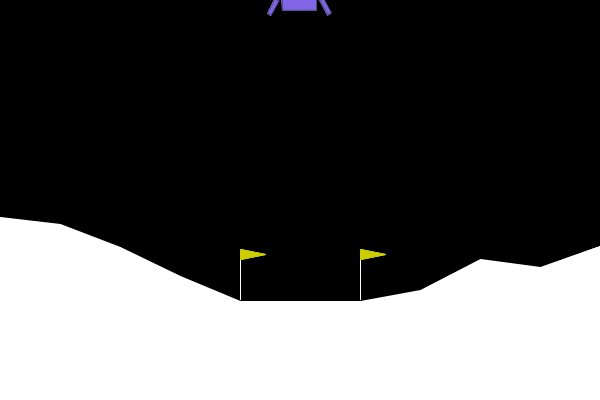

In [29]:
q_network = torch.load("dqn_priority_q_network.pth").to(device)

env = gym.make('LunarLander-v2', render_mode = 'rgb_array')
RenderWrapper.register(env, force_gif=True)

test_q_network_agent(env, q_network, num_episode=5)

env.close()

env.render_wrapper.make_gif("dqn_priority_q_network")

## Noisy Nets

In [30]:
class NoisyLayer(torch.nn.Module):
    def __init__(self, in_features, out_features, std_init=0.4):
        super(NoisyLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = torch.nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = torch.nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.empty(out_features, in_features))

        self.bias_mu = torch.nn.Parameter(torch.empty(out_features))
        self.bias_sigma = torch.nn.Parameter(torch.empty(out_features))
        self.register_buffer('bias_epsilon', torch.empty(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        mu_range = 1 / np.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / np.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / np.sqrt(self.out_features))

    def reset_noise(self):
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.outer(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def _scale_noise(self, size):
        x = torch.randn(size)
        return x.sign().mul_(x.abs().sqrt_())

    def forward(self, input):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return torch.nn.functional.linear(input, weight, bias)


In [31]:
class QNoisyNetwork(torch.nn.Module):
    """
    A Q-Network implemented with PyTorch.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        First fully connected layer.
    layer2 : torch.nn.Linear
        Second fully connected layer.
    layer3 : torch.nn.Linear
        Third fully connected layer.

    Methods
    -------
    forward(x: torch.Tensor) -> torch.Tensor
        Define the forward pass of the QNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int, nn_l1: int, nn_l2: int):
        """
        Initialize a new instance of QNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        nn_l1 : int
            The number of neurons on the first layer.
        nn_l2 : int
            The number of neurons on the second layer.
        """
        super(QNoisyNetwork, self).__init__()

        # TODO...

        self.layer1 = NoisyLayer(n_observations, nn_l1)
        self.layer2 = NoisyLayer(nn_l1, nn_l2)
        self.layer3 = NoisyLayer(nn_l2, n_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define the forward pass of the QNetwork.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor (state).

        Returns
        -------
        torch.Tensor
            The output tensor (Q-values).
        """

        # TODO...
        x = x.to(device)

        x = self.layer1(x)
        x = torch.relu(x)

        x = self.layer2(x)
        x = torch.relu(x)

        x = self.layer3(x)

        return x

    def reset_noise(self):
        self.layer1.reset_noise()
        self.layer2.reset_noise()
        self.layer3.reset_noise()

Episode reward: -109.47086135481507
Episode reward: -8.315592635053292
Episode reward: -135.45666768360798
Episode reward: -33.855061521834614
Episode reward: 5.349017074677064


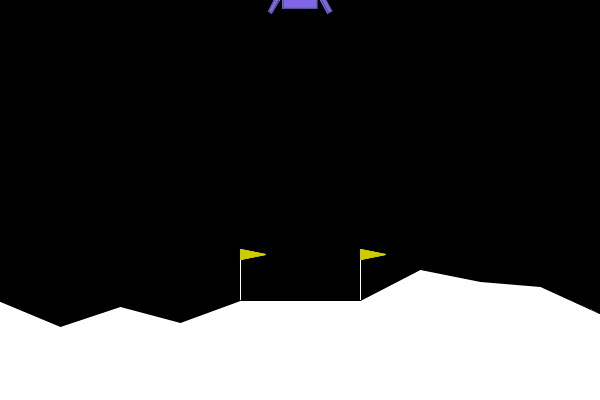

In [32]:
q_network = torch.load("online_q_network_noisy.pth").to(device)

env = gym.make('LunarLander-v2', render_mode = 'rgb_array')
RenderWrapper.register(env, force_gif=True)

test_q_network_agent(env, q_network, num_episode=5)

env.close()

env.render_wrapper.make_gif("q_network_noisy")